In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

from fia.plots import PerformancePlotter

/Users/maicolrodrigues/Documents/Test/FIA/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
FILENAME = "./data/Base.csv"
df = pd.read_csv(FILENAME)
df.shape

(1000000, 32)

In [3]:
df.columns

Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month'],
      dtype='object')

In [4]:
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


In [5]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns

label_encoders = {}
for col in categorical_features:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

# Separate features and target
X = df.drop('fraud_bool', axis=1).values
y = df['fraud_bool'].values

# Scale numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Stratified split of data into train and temp sets, maintaining the proportion of fraud cases
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, shuffle=True, random_state=42)

# Stratified split of the temp set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, shuffle=True, random_state=42)


# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

In [6]:
class FraudDetectionModel(nn.Module):
    def __init__(self, input_dim):
        super(FraudDetectionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)  # Batch normalization after first layer
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)   # Batch normalization after second layer
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Dropout with 50% probability

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)  # Apply dropout after activation
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)  # Apply dropout after activation
        x = self.fc3(x)  # No activation function here (output is logits)
        return x


input_dim = X_train.shape[1]
model = FraudDetectionModel(input_dim)

# Initialize the loss function with class weights
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor[1])
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

Epoch 1/20, Train Loss: 0.6908, Val Loss: 0.6468
Epoch 2/20, Train Loss: 0.6628, Val Loss: 0.6432
Epoch 3/20, Train Loss: 0.6581, Val Loss: 0.6348
Epoch 4/20, Train Loss: 0.6524, Val Loss: 0.6318
Epoch 5/20, Train Loss: 0.6443, Val Loss: 0.6316
Epoch 6/20, Train Loss: 0.6442, Val Loss: 0.6302
Epoch 7/20, Train Loss: 0.6460, Val Loss: 0.6297
Epoch 8/20, Train Loss: 0.6431, Val Loss: 0.6261
Epoch 9/20, Train Loss: 0.6399, Val Loss: 0.6257
Epoch 10/20, Train Loss: 0.6403, Val Loss: 0.6254
Epoch 11/20, Train Loss: 0.6393, Val Loss: 0.6229
Epoch 12/20, Train Loss: 0.6392, Val Loss: 0.6236
Epoch 13/20, Train Loss: 0.6387, Val Loss: 0.6220
Epoch 14/20, Train Loss: 0.6386, Val Loss: 0.6224
Epoch 15/20, Train Loss: 0.6367, Val Loss: 0.6228
Epoch 16/20, Train Loss: 0.6378, Val Loss: 0.6199
Epoch 17/20, Train Loss: 0.6367, Val Loss: 0.6240
Epoch 18/20, Train Loss: 0.6399, Val Loss: 0.6239
Epoch 19/20, Train Loss: 0.6403, Val Loss: 0.6197
Epoch 20/20, Train Loss: 0.6363, Val Loss: 0.6162
Accuracy:

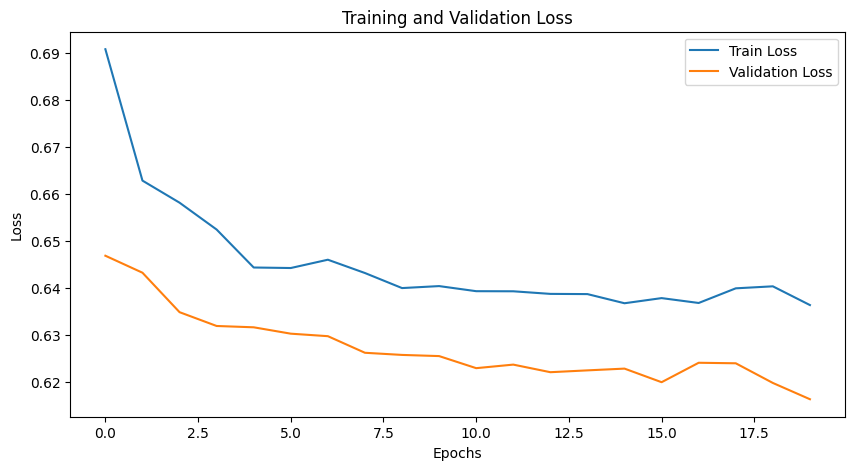

In [7]:

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                running_val_loss += loss.item() * inputs.size(0)

        val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    return train_losses, val_losses

# Train the model
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20)

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_probs = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).squeeze().cpu().numpy()  # Apply sigmoid to logits
            y_probs.extend(probs)
            y_true.extend(targets.cpu().numpy())

    y_probs = np.array(y_probs)
    y_preds = np.round(y_probs)  # Convert probabilities to binary predictions
    
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)

    print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

    return y_true, y_probs

# Evaluate the model on the test set
y_true, y_probs = evaluate_model(model, test_loader)

# Plotting loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

Accuracy: 0.8923, Precision: 0.0677, Recall: 0.6868


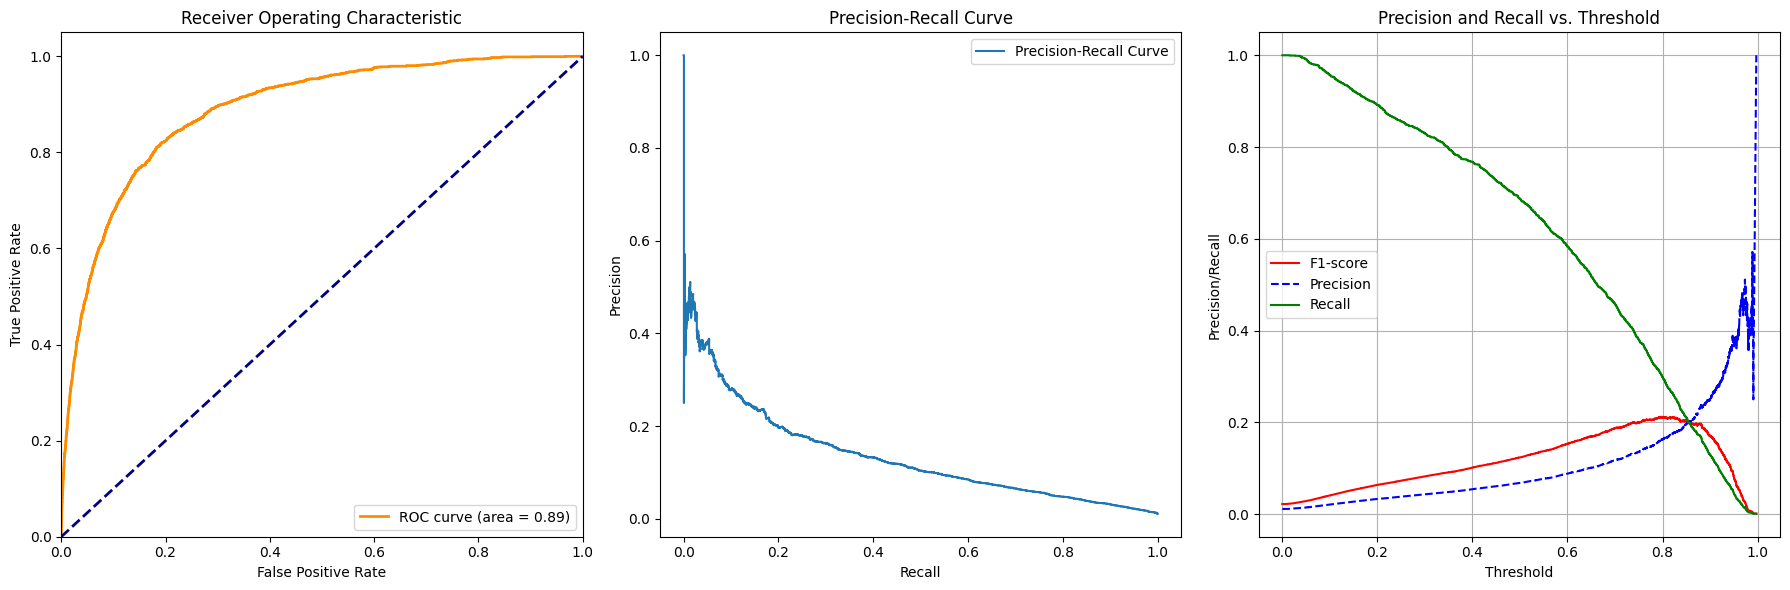

In [8]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_probs = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).squeeze().cpu().numpy()  # Apply sigmoid to logits
            y_probs.extend(probs)
            y_true.extend(targets.cpu().numpy())

    y_probs = np.array(y_probs)
    y_preds = np.round(y_probs)  # Convert probabilities to binary predictions
    
    accuracy = accuracy_score(y_true, y_preds)
    
    # Ensure there are both classes in the predictions
    if len(np.unique(y_true)) == 2:
        precision = precision_score(y_true, y_preds, average='binary')
        recall = recall_score(y_true, y_preds, average='binary')
    else:
        precision = precision_score(y_true, y_preds, average='macro')
        recall = recall_score(y_true, y_preds, average='macro')

    print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

    return y_true, y_probs

# Evaluate the model on the test set
y_true, y_probs = evaluate_model(model, test_loader)


# Use the PerformancePlotter to visualize metrics
plotter = PerformancePlotter()
plotter.plot_metrics(y_true, y_probs)
